In [1]:
### Generic imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats

### ML imports
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

### Plot setup
plt.rcParams.update({
    'figure.dpi': 150,
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

### Load data & preprocess

In [30]:
file = "/data0/mpettee/gaia_data/GD1-circle-140-30-15.pkl"
df = np.load(file, allow_pickle = True)

### Select columns
columns = ['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','streammask']
df = df[columns]

### Create b-r & g columns; rename others
df["b-r"] = df.phot_bp_mean_mag - df.phot_rp_mean_mag
df.drop(columns = ['phot_bp_mean_mag','phot_rp_mean_mag'], inplace=True)
df.rename(columns={'phot_g_mean_mag': 'g', 
                   'pmra': 'mu_ra',
                   'pmdec': 'mu_dec'}, inplace=True)

### Drop any rows containing a NaN value
df.dropna(inplace = True)

### Restrict data to a radius of 15
center_ra = df.ra.mean()
center_dec = df.dec.mean()
df = df[np.sqrt((df.dec-center_dec)**2+(df.ra-center_ra)**2) < 15]

### Construct GD1 DataFrame
gd1 = df[df.streammask == True]

# ### Exclude GD1 from main DataFrame
# df = df[df.streammask == False]

### Visualize the data

First, a plot in angular spatial coordinates, highlighting GD1:

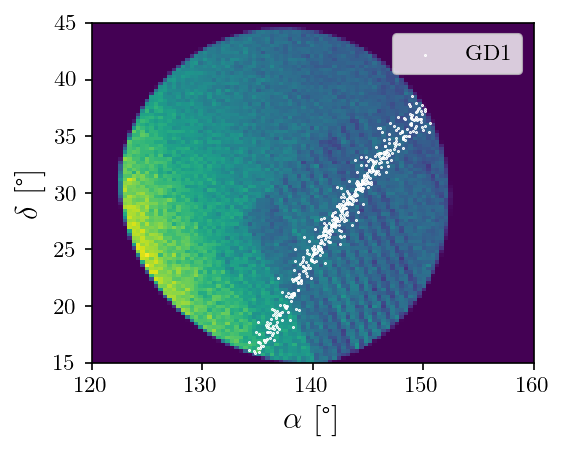

In [31]:
plt.figure(figsize=(3.8,3)) # kind of a squishy circle
plt.hist2d(df.ra,df.dec,bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gd1.ra,gd1.dec,color='white',s=0.2, label="GD1")
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]")
plt.legend();

Next, the angular velocities for the background:

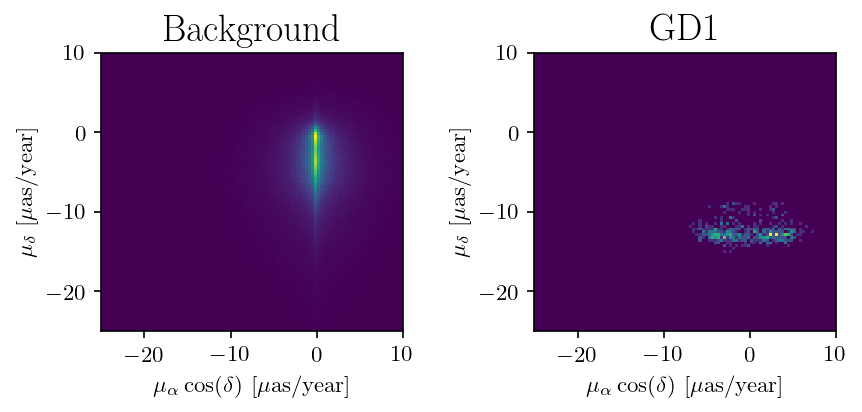

In [32]:
bins = np.linspace(-25,10,100)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3), tight_layout=True)

ax = axs[0]
ax.hist2d(df.mu_ra*np.cos(df.dec),df.mu_dec, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("Background")

ax = axs[1]
ax.hist2d(gd1.mu_ra*np.cos(gd1.dec),gd1.mu_dec, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("GD1");

### Define the signal & sideband regions

We want to pick a variable that is relatively localized for GD1. Comparing these two angular velocities, it's clear that we should pick $\mu_\delta$, as its distribution is narrower:

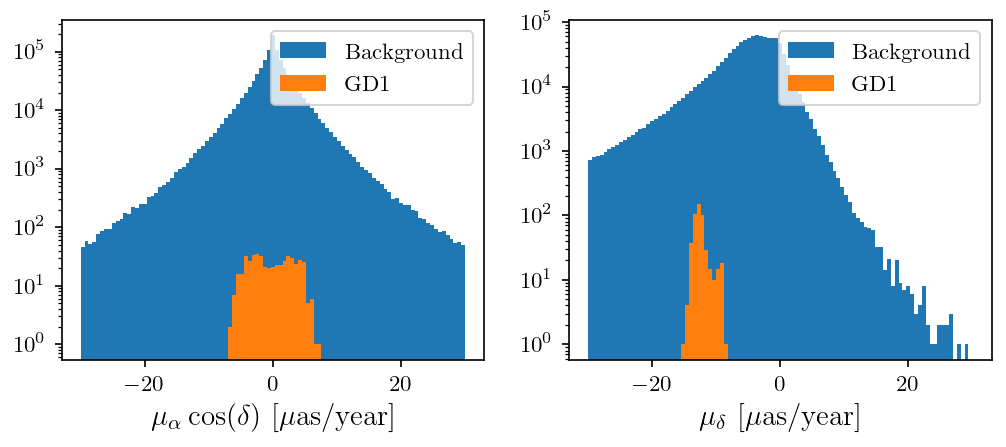

In [33]:
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
ax = axs[0]
ax.hist(df.mu_ra*np.cos(df.dec), bins = np.linspace(-30,30,100), label="Background")
ax.hist(gd1.mu_ra*np.cos(gd1.dec), bins = np.linspace(-30,30,100), label="GD1")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=14)

ax = axs[1]
ax.hist(df.mu_dec, bins = np.linspace(-30,30,100), label="Background")
ax.hist(gd1.mu_dec, bins = np.linspace(-30,30,100), label="GD1")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=14);

Now we'll define the signal & sideband regions for this variable:

In [34]:
signal = df[((df.mu_dec > -15) & (df.mu_dec < -11))]
sideband = df[(((df.mu_dec > -18) & (df.mu_dec < -15)) | ((df.mu_dec > -11) & (df.mu_dec < -9.5)))]

Scale and rotate the datasets (why?):

In [35]:
# def rotate(x, y, θ):
#     return (x*np.cos(θ) + y*np.sin(θ), -x*np.sin(θ) + y*np.cos(θ))

In [36]:
# Xr, Yr = rotate(signal.ra-center_ra, signal.dec-center_dec, -0.5)
# Xbr, Ybr = rotate(sideband.ra-center_ra, sideband.dec-center_dec, -0.5)
# Xsr, Ysr = rotate(gd1.ra-center_ra, gd1.dec-center_dec, -0.5)

# signal["x"] = Xr
# sideband["x"] = Xbr
# gd1["x"] = Xsr

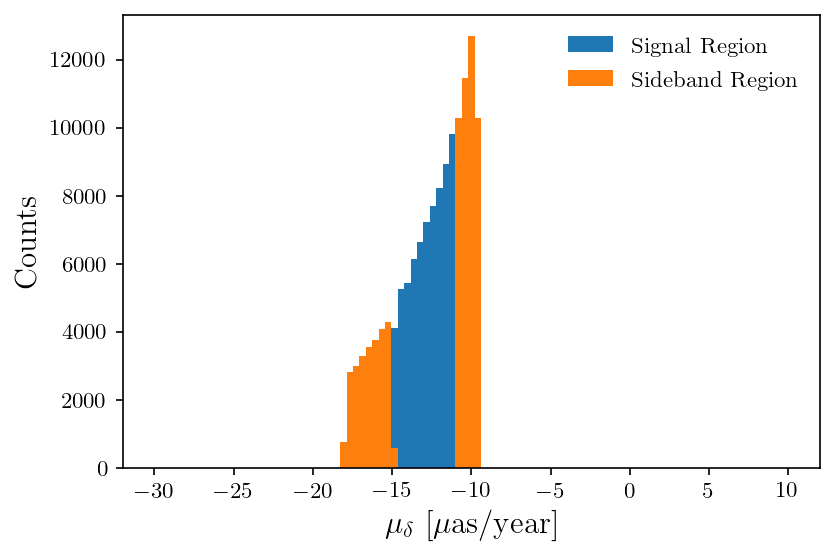

In [37]:
bins = np.linspace(-30,10,100)
plt.hist(signal.mu_dec,bins=bins,label="Signal Region")
plt.hist(sideband.mu_dec,bins=bins,label="Sideband Region")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("Counts");

### Prepare datasets for training

In [41]:
training_vars = ['mu_dec', 'mu_ra', 'dec', 'ra', 'g', 'b-r'] 

In [43]:
X = np.concatenate([signal[training_vars],sideband[training_vars]])
Y = np.concatenate([np.ones(len(signal)),np.zeros(len(sideband))])

sc = preprocessing.StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

In [45]:
def split(data, num_splits):
    res = []
    curr = 0
    diff = len(data)//num_splits
    while curr < num_splits:
        res.append(data[curr*diff:(curr+1)*diff])
        curr += 1
    return res

In [46]:
num_splits = 5
split_X = split(X_scaled, num_splits)
split_Y = split(Y, num_splits)

### Train CWoLa model

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train[:,1:], Y_train, 
                    epochs=20, 
                    batch_size=200,
                    validation_data=(X_test[:,1:],Y_test))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))

In [ ]:
plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("NN")

In [ ]:
preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))